In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import files

In [3]:
# Check if GPU is available to speed up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Set seed to reduce variation
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## Model 1 - DistilBERT fine tuning only classification head, dropout=0.3

In [6]:
# Define the model
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

## Model 2 - DistilBERT fine tuning last 2 transformer layers, droupout=0.3

In [7]:
class DistilBERTClassifier2(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier2, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Unfreeze some layers for fine-tuning
        for param in self.distilbert.parameters():
            param.requires_grad = False  # Freeze all layers initially

        for param in self.distilbert.transformer.layer[-2:].parameters():
            param.requires_grad = True  # Unfreeze last 2 layers

        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

## Model 3 - DistilBERT fine tuning last 4 transformer layers, dropout=0.3

In [8]:
class DistilBERTClassifier3(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier3, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Unfreeze some layers for fine-tuning
        for param in self.distilbert.parameters():
            param.requires_grad = False  # Freeze all layers initially

        for param in self.distilbert.transformer.layer[-4:].parameters():
            param.requires_grad = True  # Unfreeze last 4 layers

        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

## Model 4 - DistilBERT fine tuning last 4 transformer layers and classification head, dropout =0.4

In [9]:
class DistilBERTClassifier4(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier4, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Unfreeze some layers for fine-tuning
        for param in self.distilbert.parameters():
            param.requires_grad = False  # Freeze all layers initially

        for param in self.distilbert.transformer.layer[-4:].parameters():
            param.requires_grad = True  # Unfreeze last 4 layers

        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

## Other methods

In [11]:
# Define training function
def train(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(iterator)

In [12]:
# Define evaluation function
def evaluate(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, labels)

            total_loss += loss.item()

    return total_loss / len(iterator)

In [13]:
# Define prediction function
def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)  # Assuming input_ids are in the batch
            attention_mask = batch['attention_mask'].to(device)  # Assuming attention_mask is in the batch

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Convert predictions to CPU and append to the list
            predictions.extend(preds.cpu().numpy())

    return predictions

In [14]:
# Load files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Read datasets from csv and load into arrays
train_data = np.genfromtxt('drive/My Drive/Colab Notebooks/train_text_labels.csv', delimiter=',', dtype=str, encoding=None)
text_train = train_data[:,0]
labels_train = train_data[:,1].astype(int)

val_data = np.genfromtxt('drive/My Drive/Colab Notebooks/val_text_labels.csv', delimiter=',', dtype=str, encoding=None)
text_val = val_data[:, 0]
labels_val = val_data[:, 1].astype(int)

test_data = np.genfromtxt('drive/My Drive/Colab Notebooks/test_text_labels.csv', delimiter=',', dtype=str, encoding=None)
text_test = test_data[:, 0]
labels_test = test_data[:, 1].astype(int)

In [16]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize data
max_len = 24
dataset_train = CustomDataset(text_train, labels_train, tokenizer, max_len)
dataset_val = CustomDataset(text_val, labels_val, tokenizer, max_len)
dataset_test = CustomDataset(text_test, labels_test, tokenizer, max_len)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [17]:
# Data loaders
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)

In [ ]:
best_loss = 1e+10 # best loss tracker
EPOCHS = 8

# Early Stopping parameters
patience = 2  # Stop training if `val_loss` does not improve within this number of epochs
global_best_accuracy = 0.1  # Track the best test accuracy

## Training with model 1 - 8 epoch

In [ ]:
# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBERTClassifier(num_classes=4).to(device)

# Training parameters
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f'Epoch: {epoch+1}, Val Loss: {val_loss:.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

Epoch: 1, Train Loss: 0.4605
Epoch: 1, Val Loss: 0.3401
Epoch: 2, Train Loss: 0.2734
Epoch: 2, Val Loss: 0.3261
Epoch: 3, Train Loss: 0.2124
Epoch: 3, Val Loss: 0.3217
Epoch: 4, Train Loss: 0.1726
Epoch: 4, Val Loss: 0.3606
Epoch: 5, Train Loss: 0.1435
Epoch: 5, Val Loss: 0.3526
Epoch: 6, Train Loss: 0.1283
Epoch: 6, Val Loss: 0.3469
Epoch: 7, Train Loss: 0.1133
Epoch: 7, Val Loss: 0.3832
Epoch: 8, Train Loss: 0.1056
Epoch: 8, Val Loss: 0.4142


In [ ]:
model.load_state_dict(torch.load('best_model_1.pth'))
# Evaluation
test_predictions = predict(model, test_loader, device)
print(f"Accuracy:  {(test_predictions == labels_test).sum()/labels_test.size:.4f}")

<ipython-input-70-b575b4b2446f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_1.pth'))


Accuracy:  0.8400


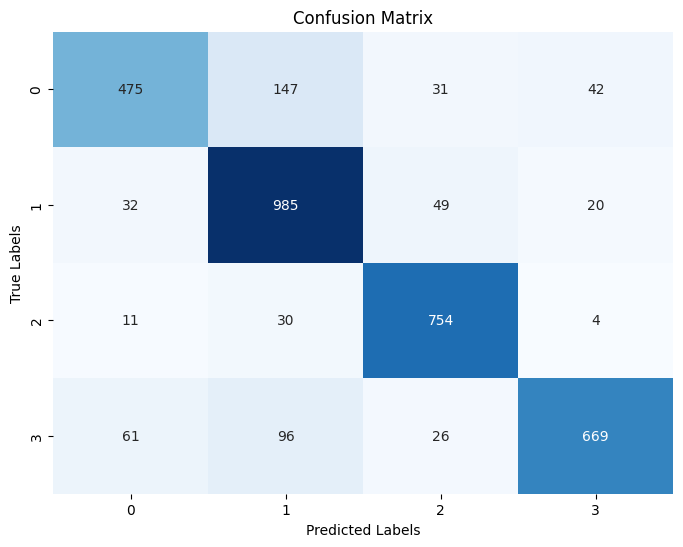

In [ ]:
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Model 1 - 5 rounds
### result: best accuracy 0.8537, average accuracy 0.8457


In [ ]:
for i in range(5):  # Train for 5 rounds
    print(f"Training round: {i+1}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DistilBERTClassifier(num_classes=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Track the best `val_loss`
    best_loss = float("inf")
    best_model_path = "best_model_temp.pth"

    early_stop_counter = 0  # Count consecutive epochs without improvement

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = train(model, train_loader, optimizer, criterion, device)

        model.eval()
        val_loss = evaluate(model, val_loader, criterion, device)

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model (based on val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f" Best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")
            early_stop_counter = 0  # Reset the counter
        else:
            early_stop_counter += 1  # Increase counter for overfitting detection

        # Early Stopping: Stop training if `val_loss` does not improve for `patience` epochs
        if early_stop_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

    # Load the best model based on `val_loss`
    model.load_state_dict(torch.load(best_model_path, weights_only=True))

    # Evaluate on the test set
    test_predictions = predict(model, test_loader, device)
    accuracy = (test_predictions == labels_test).sum()/labels_test.size

    print(f"Test Accuracy: {accuracy:.4f}")

    # Track the globally best model (based on test accuracy)）
    if accuracy > global_best_accuracy:
        global_best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model_1.pth")
        print(f" New Best Model Saved with Accuracy: {global_best_accuracy:.4f}")

print(f"\n Final Best Test Accuracy: {global_best_accuracy:.4f}")

files.download('/content/best_model_1.pth')

Training round: 1
Epoch: 1, Train Loss: 0.4705, Val Loss: 0.3551
 Best model saved at epoch 1 with val_loss: 0.3551
Epoch: 2, Train Loss: 0.2761, Val Loss: 0.3008
 Best model saved at epoch 2 with val_loss: 0.3008
Epoch: 3, Train Loss: 0.2157, Val Loss: 0.3205
Epoch: 4, Train Loss: 0.1788, Val Loss: 0.3363
 Early stopping at epoch 4


<ipython-input-74-18ba5785509d>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.8470
 New Best Model Saved with Accuracy: 0.8470
Training round: 2
Epoch: 1, Train Loss: 0.4647, Val Loss: 0.3221
 Best model saved at epoch 1 with val_loss: 0.3221
Epoch: 2, Train Loss: 0.2774, Val Loss: 0.3035
 Best model saved at epoch 2 with val_loss: 0.3035
Epoch: 3, Train Loss: 0.2181, Val Loss: 0.2908
 Best model saved at epoch 3 with val_loss: 0.2908
Epoch: 4, Train Loss: 0.1770, Val Loss: 0.3781
Epoch: 5, Train Loss: 0.1466, Val Loss: 0.3263
 Early stopping at epoch 5
Test Accuracy: 0.8520
 New Best Model Saved with Accuracy: 0.8520
Training round: 3
Epoch: 1, Train Loss: 0.4572, Val Loss: 0.3286
 Best model saved at epoch 1 with val_loss: 0.3286
Epoch: 2, Train Loss: 0.2766, Val Loss: 0.3160
 Best model saved at epoch 2 with val_loss: 0.3160
Epoch: 3, Train Loss: 0.2206, Val Loss: 0.3162
Epoch: 4, Train Loss: 0.1723, Val Loss: 0.3457
 Early stopping at epoch 4
Test Accuracy: 0.8392
Training round: 4
Epoch: 1, Train Loss: 0.4641, Val Loss: 0.3488
 Best model s

## Model 2 - 10 rounds
### result: best accuracy 0.8494, average accuracy 0.8423

In [ ]:
for i in range(10):  # Train for 10 rounds
    print(f"Training round: {i+1}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DistilBERTClassifier2(num_classes=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Track the best `val_loss`
    best_loss = float("inf")
    best_model_path = "best_model_temp.pth"

    early_stop_counter = 0  # Count consecutive epochs without improvement

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = train(model, train_loader, optimizer, criterion, device)

        model.eval()
        val_loss = evaluate(model, val_loader, criterion, device)

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model (based on val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f" Best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")
            early_stop_counter = 0  # Reset the counter
        else:
            early_stop_counter += 1  # Increase counter for overfitting detection

        # Early Stopping: Stop training if `val_loss` does not improve for `patience` epochs
        if early_stop_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

    # Load the best model based on `val_loss`
    model.load_state_dict(torch.load(best_model_path, weights_only=True))

    # Evaluate on the test set
    test_predictions = predict(model, test_loader, device)
    accuracy = (test_predictions == labels_test).sum()/labels_test.size

    print(f"Test Accuracy: {accuracy:.4f}")

    # Track the globally best model (based on test accuracy)）
    if accuracy > global_best_accuracy:
        global_best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model_2.pth")
        print(f" New Best Model Saved with Accuracy: {global_best_accuracy:.4f}")

print(f"\n Final Best Test Accuracy: {global_best_accuracy:.4f}")

files.download('/content/best_model_2.pth')

Training round: 1
Epoch: 1, Train Loss: 0.5612, Val Loss: 0.3851
 Best model saved at epoch 1 with val_loss: 0.3851
Epoch: 2, Train Loss: 0.3651, Val Loss: 0.3423
 Best model saved at epoch 2 with val_loss: 0.3423
Epoch: 3, Train Loss: 0.3116, Val Loss: 0.3186
 Best model saved at epoch 3 with val_loss: 0.3186
Epoch: 4, Train Loss: 0.2805, Val Loss: 0.3145
 Best model saved at epoch 4 with val_loss: 0.3145
Epoch: 5, Train Loss: 0.2494, Val Loss: 0.3061
 Best model saved at epoch 5 with val_loss: 0.3061
Epoch: 6, Train Loss: 0.2251, Val Loss: 0.3053
 Best model saved at epoch 6 with val_loss: 0.3053
Epoch: 7, Train Loss: 0.2097, Val Loss: 0.3115
Epoch: 8, Train Loss: 0.1879, Val Loss: 0.3070
 Early stopping at epoch 8
Test Accuracy: 0.8476
 New Best Model Saved with Accuracy: 0.8476
Training round: 2
Epoch: 1, Train Loss: 0.5589, Val Loss: 0.3850
 Best model saved at epoch 1 with val_loss: 0.3850
Epoch: 2, Train Loss: 0.3740, Val Loss: 0.3599
 Best model saved at epoch 2 with val_loss: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 3 - 10 rounds
### result: best accuracy 0.8523, average accuracy 0.8439

In [ ]:
for i in range(10):  # Train for 10 rounds
    print(f"Training round: {i+1}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DistilBERTClassifier3(num_classes=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Track the best `val_loss`
    best_loss = float("inf")
    best_model_path = "best_model_temp.pth"

    early_stop_counter = 0  # Count consecutive epochs without improvement

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = train(model, train_loader, optimizer, criterion, device)

        model.eval()
        val_loss = evaluate(model, val_loader, criterion, device)

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model (based on val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f" Best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")
            early_stop_counter = 0  # Reset the counter
        else:
            early_stop_counter += 1  # Increase counter for overfitting detection

        # Early Stopping: Stop training if `val_loss` does not improve for `patience` epochs
        if early_stop_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

    # Load the best model based on `val_loss`
    model.load_state_dict(torch.load(best_model_path, weights_only=True))

    # Evaluate on the test set
    test_predictions = predict(model, test_loader, device)
    accuracy = (test_predictions == labels_test).sum()/labels_test.size

    print(f"Test Accuracy: {accuracy:.4f}")

    # Track the globally best model (based on test accuracy)）
    if accuracy > global_best_accuracy:
        global_best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model_3.pth")
        print(f" New Best Model Saved with Accuracy: {global_best_accuracy:.4f}")

print(f"\n Final Best Test Accuracy: {global_best_accuracy:.4f}")

files.download('/content/best_model_3.pth')

Training round: 1
Epoch: 1, Train Loss: 0.5084, Val Loss: 0.3566
 Best model saved at epoch 1 with val_loss: 0.3566
Epoch: 2, Train Loss: 0.3141, Val Loss: 0.3235
 Best model saved at epoch 2 with val_loss: 0.3235
Epoch: 3, Train Loss: 0.2553, Val Loss: 0.3304
Epoch: 4, Train Loss: 0.2190, Val Loss: 0.3098
 Best model saved at epoch 4 with val_loss: 0.3098
Epoch: 5, Train Loss: 0.1872, Val Loss: 0.3039
 Best model saved at epoch 5 with val_loss: 0.3039
Epoch: 6, Train Loss: 0.1607, Val Loss: 0.3159
Epoch: 7, Train Loss: 0.1476, Val Loss: 0.3232
 Early stopping at epoch 7
Test Accuracy: 0.8444
 New Best Model Saved with Accuracy: 0.8444
Training round: 2
Epoch: 1, Train Loss: 0.5058, Val Loss: 0.3429
 Best model saved at epoch 1 with val_loss: 0.3429
Epoch: 2, Train Loss: 0.3181, Val Loss: 0.3121
 Best model saved at epoch 2 with val_loss: 0.3121
Epoch: 3, Train Loss: 0.2536, Val Loss: 0.3097
 Best model saved at epoch 3 with val_loss: 0.3097
Epoch: 4, Train Loss: 0.2223, Val Loss: 0.31

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 4 - 10 rounds
### result: best accuracy 0.8485, average accuracy 0.8418

In [ ]:
for i in range(10):  # Train for 10 rounds
    print(f"Training round: {i+1}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DistilBERTClassifier4(num_classes=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Track the best `val_loss`
    best_loss = float("inf")
    best_model_path = "best_model_temp.pth"

    early_stop_counter = 0  # Count consecutive epochs without improvement

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = train(model, train_loader, optimizer, criterion, device)

        model.eval()
        val_loss = evaluate(model, val_loader, criterion, device)

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model (based on val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f" Best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")
            early_stop_counter = 0  # Reset the counter
        else:
            early_stop_counter += 1  # Increase counter for overfitting detection

        # Early Stopping: Stop training if `val_loss` does not improve for `patience` epochs
        if early_stop_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

    # Load the best model based on `val_loss`
    model.load_state_dict(torch.load(best_model_path, weights_only=True))

    # Evaluate on the test set
    test_predictions = predict(model, test_loader, device)
    accuracy = (test_predictions == labels_test).sum()/labels_test.size

    print(f"Test Accuracy: {accuracy:.4f}")

    # Track the globally best model (based on test accuracy)）
    if accuracy > global_best_accuracy:
        global_best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model_4.pth")
        print(f" New Best Model Saved with Accuracy: {global_best_accuracy:.4f}")

print(f"\n Final Best Test Accuracy: {global_best_accuracy:.4f}")


Training round: 1
Epoch: 1, Train Loss: 0.5149, Val Loss: 0.3594
 Best model saved at epoch 1 with val_loss: 0.3594
Epoch: 2, Train Loss: 0.3198, Val Loss: 0.3094
 Best model saved at epoch 2 with val_loss: 0.3094
Epoch: 3, Train Loss: 0.2643, Val Loss: 0.3106
Epoch: 4, Train Loss: 0.2206, Val Loss: 0.3277
 Early stopping at epoch 4
Test Accuracy: 0.8485
 New Best Model Saved with Accuracy: 0.8485
Training round: 2
Epoch: 1, Train Loss: 0.5249, Val Loss: 0.3504
 Best model saved at epoch 1 with val_loss: 0.3504
Epoch: 2, Train Loss: 0.3251, Val Loss: 0.3336
 Best model saved at epoch 2 with val_loss: 0.3336
Epoch: 3, Train Loss: 0.2654, Val Loss: 0.3106
 Best model saved at epoch 3 with val_loss: 0.3106
Epoch: 4, Train Loss: 0.2274, Val Loss: 0.3248
Epoch: 5, Train Loss: 0.1959, Val Loss: 0.3189
 Early stopping at epoch 5
Test Accuracy: 0.8389
Training round: 3
Epoch: 1, Train Loss: 0.5175, Val Loss: 0.3423
 Best model saved at epoch 1 with val_loss: 0.3423
Epoch: 2, Train Loss: 0.3199

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the best models on Google Drive
import shutil
shutil.move("best_model_2.pth", "drive/My Drive/best_model_2.pth")
shutil.move("best_model_3.pth", "drive/My Drive/best_model_3.pth")
shutil.move("best_model_4.pth", "drive/My Drive/best_model_4.pth")

'drive/My Drive/best_model_4.pth'